<a href="https://colab.research.google.com/github/ashishsaini01/Anomaly_detection_using_autoencoders/blob/main/laten_space_siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as k
import matplotlib.pyplot as plt
import random
import cv2

from google.colab.patches import cv2_imshow
from skimage.feature import hog   
from skimage import color
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose

In [ ]:
# mounting google drive for easy data reading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = np.load('/content/drive/MyDrive/light_on_0.npz')
# print(data.files)
#x, gx, tx, new_x, ty, i, gi, ti = data['x'], data['gx'], data['tx'], data['tn'], data['i'], data['gi'], data['ti']
x, fn, i, gx, gn, gi, tx, tn, ti, new, newf, newi = data['x'], data['fn'], data['i'], data['gx'], data['gn'], data['gi'], data['tx'], data['tn'], data['ti'], data['new'], data['newf'], data['newi']

In [ ]:
x.shape, fn.shape, i.shape, gx.shape, gn.shape, gi.shape, tx.shape, tn.shape, ti.shape, new.shape, newf.shape, newi.shape

((1500, 128, 384, 3),
 (1500,),
 (1500,),
 (101, 128, 384, 3),
 (101,),
 (101,),
 (404, 128, 384, 3),
 (404,),
 (404,),
 (505, 128, 384, 3),
 (505,),
 (505,))

In [ ]:
# normalize
x_norm = x/255
g_norm = gx/255
tx_norm = tx/255
newx_norm = new/255

In [ ]:
encoding_dim = 64
input_img = tf.keras.layers.Input(shape = x_norm.shape[1:]) # input layer

# encoder
encoded = tf.keras.layers.Conv2D(encoding_dim, kernel_size = (5, 5), padding = 'same',  activation = 'relu')(input_img)
encoded = tf.keras.layers.MaxPool2D(pool_size = (2, 2),)(encoded)
encoded = tf.keras.layers.Conv2D(encoding_dim/2, kernel_size = (3, 3), padding = 'same', activation = 'relu')(encoded)
encoded = tf.keras.layers.MaxPool2D(pool_size = (2, 2),)(encoded)
encoded = tf.keras.layers.Conv2D(encoding_dim/4, kernel_size = (3, 3), padding = 'same', activation = 'relu')(encoded)
#encoded = tf.keras.layers.MaxPool2D(pool_size = (2, 2),)(encoded)
#encoded = tf.keras.layers.Conv2D(encoding_dim/4, kernel_size = (3, 3), padding = 'same', activation = 'relu')(encoded)
#encoded = tf.keras.layers.Conv2D(encoding_dim/8, kernel_size = (3, 3), padding = 'same', activation = 'relu')(encoded)
encoded = tf.keras.layers.Conv2D(3, kernel_size = (3, 3), padding = 'same', activation = 'relu')(encoded)

encoder = tf.keras.Model(input_img, encoded) # this maps an input to it's encoded representation

# decoder
decoded = tf.keras.layers.Conv2DTranspose(3, kernel_size = (3, 3), padding = 'same', activation = 'relu')(encoded)
#decoded = tf.keras.layers.Conv2D(encoding_dim/8, kernel_size = (3, 3), padding = 'same', activation = 'relu')(decoded)
#decoded = tf.keras.layers.Conv2D(encoding_dim/4, kernel_size = (3, 3), padding = 'same', activation = 'relu')(decoded)
decoded = tf.keras.layers.Conv2DTranspose(encoding_dim/4, kernel_size = (3, 3), padding = 'same', activation = 'relu')(decoded)
decoded = tf.keras.layers.UpSampling2D(size = (2, 2),)(decoded)
decoded = tf.keras.layers.Conv2DTranspose(encoding_dim/2, kernel_size = (3, 3), padding = 'same', activation = 'relu')(decoded)
decoded = tf.keras.layers.UpSampling2D(size = (2, 2),)(decoded)
decoded = tf.keras.layers.Conv2DTranspose(3, kernel_size = (5, 5), padding = 'same', activation = 'sigmoid')(decoded)

#decoded = tf.keras.layers.Conv2DTranspose(3, (5, 5), activation='sigmoid', padding='same')(decoded)


autoencoder = tf.keras.Model(input_img, decoded) # this maps an input back to orignal state
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 384, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 384, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 192, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 192, 32)       18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 96, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 96, 16)        4624

In [ ]:
x_norm.shape

(1500, 128, 384, 3)

In [ ]:
autoencoder.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['mse'])

callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min') # for early stopping

history = autoencoder.fit(x_norm, x_norm,
                epochs=25,
                batch_size=50, shuffle=True,
                callbacks = [callback], verbose=1,
                validation_split = 0.2)

Epoch 1/25
24/24 [==============================] - 9s 225ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0079 - val_mse: 0.0079
Epoch 2/25
24/24 [==============================] - 5s 190ms/step - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0064 - val_mse: 0.0064
Epoch 3/25
24/24 [==============================] - 4s 175ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 4/25
24/24 [==============================] - 4s 187ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 5/25
24/24 [==============================] - 4s 183ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 6/25
24/24 [==============================] - 4s 188ms/step - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0054 - val_mse: 0.0054
Epoch 7/25
24/24 [==============================] - 4s 177ms/step - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0053 - val_mse: 0.0053
Epoch 8/25
24/24 [==============================] - 5s 195ms/step - loss: 0.

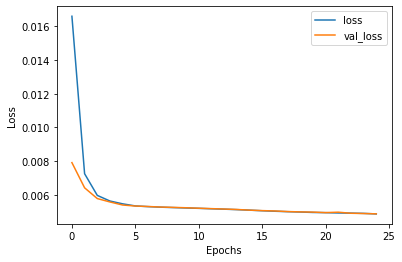

In [ ]:
# ploting 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
# latent representaion of x, g, tx
x_latent = encoder.predict(x_norm)
g_latent = encoder.predict(g_norm)
tx_latent = encoder.predict(tx_norm)
newx_latent = encoder.predict(newx_norm)

16/16 [==============================] - 1s 32ms/step


In [ ]:
pred = autoencoder.predict(g_norm)

4/4 [==============================] - 1s 55ms/step


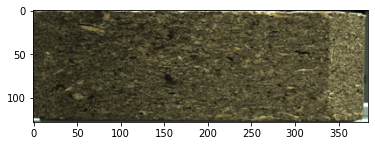

In [ ]:
plt.imshow(g_norm[1])

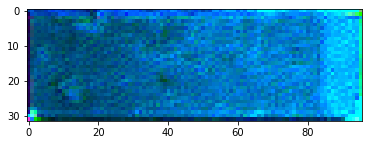

In [ ]:
plt.imshow(g_latent[1])

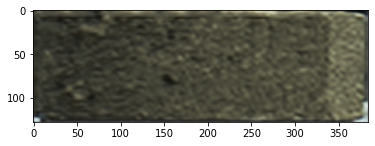

In [ ]:
plt.imshow(pred[1])

In [ ]:
#pred = model.predict(x_test)
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(g_norm[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# saving encoded representation
np.savez_compressed("/content/drive/MyDrive/light_on_latent_4.npz", x_latent = x_latent, fn = fn, i = i, g_latent = g_latent, gn = gn, gi = gi,
                    tx_latent = tx_latent, tn = tn, ti = ti, newx_latent = newx_latent, newf = newf, newi = newi)

In [ ]:
data_latent = np.load('/content/drive/MyDrive/light_on_latent_4.npz')
# print(data.files)
x_latent, fn, i, g_latent, gn, gi, tx_latent, tn, ti, newx_latent, newf, newi = data_latent['x_latent'], data_latent['fn'], data_latent['i'], data_latent['g_latent'], data_latent['gn'], data_latent['gi'], data_latent['tx_latent'], data_latent['tn'], data_latent['ti'], data_latent['newx_latent'], data_latent['newf'], data_latent['newi']

In [ ]:
x_latent.shape, g_latent.shape, tx_latent.shape, newx_latent.shape

((1505, 32, 96, 3), (100, 32, 96, 3), (400, 32, 96, 3), (505, 32, 96, 3))

In [ ]:
# training siamene network on encoded representation of input

In [ ]:
# creating batchs for traning (anchor, positive, and, negative (for triplet loss))
def create_batch(batch_size=500):
    x_anchors = np.zeros((batch_size, 32, 96, 3))
    x_positives = np.zeros((batch_size, 32, 96, 3))
    x_negatives = np.zeros((batch_size, 32, 96, 3))
    
    for j in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, x_latent.shape[0] - 1)
        x_anchor = x_latent[random_index]

        pos_index = random.randint(0, x_latent.shape[0] - 1)

        while pos_index == random_index or i[pos_index] != i[random_index]:
          pos_index = random.randint(0, x_latent.shape[0] - 1)

        x_positive = x_latent[pos_index]  # also for the same pallet block
        
        random_index_neg = random.randint(0, x_latent.shape[0] - 1)

        while random_index_neg == random_index or i[random_index] == i[random_index_neg]:
          random_index_neg = random.randint(0, x_latent.shape[0] - 1)
         
        x_negative = x_latent[random_index_neg]
        
        x_anchors[j] = x_anchor
        x_positives[j] = x_positive
        x_negatives[j] = x_negative
        
    x_anchors = np.expand_dims(x_anchors, axis = 1)
    x_positives = np.expand_dims(x_positives, axis = 1)
    x_negatives = np.expand_dims(x_negatives, axis = 1)

    k_con = np.concatenate([x_anchors, x_positives, x_negatives], axis = 1)
        
    return k_con

In [ ]:
# embeding model
emb_size = 64

embedding_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(emb_size, kernel_size = (5, 5), strides = 2, padding = 'same', activation = 'relu', input_shape = (32, 96, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(emb_size, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(emb_size/2, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(emb_size/4, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(emb_size/4, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(50)
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 48, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 16, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 24, 64)        0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 8, 24, 64)        256       
 hNormalization)                                                 
                                                        

In [ ]:
# siamese network
siamese_input = tf.keras.Input(shape = (3, 32, 96, 3))
input_anchor =  siamese_input[:, 0]                                              #tf.keras.layers.Input(shape=(32, 96, 3))
input_positive = siamese_input[:, 1]                                             #tf.keras.layers.Input(shape=(32, 96, 3))
input_negative = siamese_input[:, 2]                                             #tf.keras.layers.Input(shape=(32, 96, 3))

embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

embedding_anchor = k.expand_dims(embedding_anchor, 1)
embedding_negative = k.expand_dims(embedding_negative, 1)
embedding_positive = k.expand_dims(embedding_positive, 1)


output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1) 

model = tf.keras.models.Model(siamese_input, output)
model.summary()
     

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 32, 96,   0           []                               
                                3)]                                                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 32, 96, 3)   0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 32, 96, 3)   0           ['input_1[0][0]']                
 icingOpLambda)                                                                               

In [ ]:
alpha = 0.01

pos = k.mean((embedding_anchor - embedding_positive)**2, axis = 1)
neg = k.mean((embedding_anchor - embedding_negative)**2, axis = 1)

loss = k.mean(k.relu(pos - neg + alpha)) 

In [ ]:
batch_size = 15000
x_train = create_batch(batch_size)
x_train = np.array(x_train)
x_train.shape

(15000, 3, 32, 96, 3)

In [ ]:
# batch_size = 2048
epochs = 32
# steps_per_epoch = 25

model.add_loss(loss)


model.compile(optimizer='adam')

callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min') # for early stopping

history = model.fit(
    x_train,
    batch_size = 100,
    epochs=epochs, verbose=True, callbacks = [callback], validation_split = 0.2)

Epoch 1/32
120/120 [==============================] - 23s 55ms/step - loss: 0.0343 - val_loss: 0.0098
Epoch 2/32
120/120 [==============================] - 6s 47ms/step - loss: 0.0099 - val_loss: 0.0082
Epoch 3/32
120/120 [==============================] - 5s 44ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 4/32
120/120 [==============================] - 5s 46ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 5/32
120/120 [==============================] - 5s 44ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 6/32
120/120 [==============================] - 6s 49ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 7/32
120/120 [==============================] - 6s 47ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 8/32
120/120 [==============================] - 5s 45ms/step - loss: 0.0036 - val_loss: 0.0056
Epoch 9/32
120/120 [==============================] - 5s 44ms/step - loss: 0.0031 - val_loss: 0.0063
Epoch 10/32
120/120 [==============================] - 6s 47ms/step - loss: 0.0030 - val_l

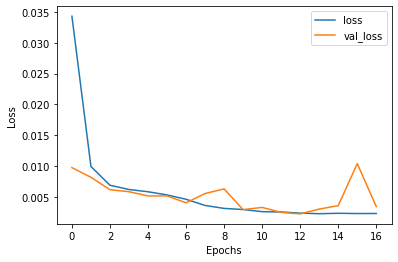

In [ ]:
# ploting 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
# predictions
x_predict = embedding_model.predict(x_latent)
g_predict = embedding_model.predict(g_latent)
tx_predict = embedding_model.predict(tx_latent)
newx_predict = embedding_model.predict(newx_latent)

16/16 [==============================] - 0s 7ms/step


In [ ]:
bool_ls = []
for n in range(0, tx_predict.shape[0]):
  if tn[n] == 1: continue
  p_2 = tx_predict[n]
  sub = g_predict - p_2
  dist = np.mean((sub)**2, axis = 1)
  min_index = np.argsort(dist)[:1]
  if (gi[min_index] == ti[n]).any(): bool_ls.append(1)
  else: bool_ls.append(0)

In [ ]:
np.mean(bool_ls)

0.0525

In [ ]:
# saving siamese predictions
#np.savez_compressed("/content/drive/MyDrive/light_on_siamese_0.npz", x_predict = x_predict, g_predict = g_predict, t_predict = t_predict, ty = ty, i = i, gi = gi, ti = ti)

In [ ]:
# saving encoded representation
np.savez_compressed("/content/drive/MyDrive/light_on_siamese_4.npz", x_predict = x_predict, fn = fn, i = i, g_predict = g_predict, gn = gn, gi = gi,
                    tx_predict = tx_predict, tn = tn, ti = ti, newx_predict = newx_predict, newf = newf, newi = newi)